In [68]:
# Copyright 2017 The Rudders Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License 

ERROR! Session/line number was not unique in database. History logging moved to new session 109


# Load data

In [3]:
import base64
import json

from dataclasses import dataclass, field
from datetime import datetime
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np

SEED = 42

def convert_embedding_to_array(sentence):
    return np.frombuffer(base64.b64decode(sentence.embedding["tensor"]['tensorContent']), dtype='float32')

@dataclass
class Sentence():
    text: str
    embedding: dict
    review_id: str
    
    def to_array(self):
        return convert_embedding_to_array(self)

@dataclass
class Review():
    review_id: str
    user_id: str
    movie_id: str
    date: datetime
    score: float
    sentences: list = field(default_factory=list)
    split: str = "train" 
        
    def add_sentence(self, sentence):
        self.sentences.append(sentence)
    
    def __len__(self):
        return len(self.sentences)
    
    def __iter__(self):
        return iter(self.sentences)
            

def review_sentences_generator(review_ids):
    for review_id in review_ids:
        for sentence in reviews[review_id]:
            yield sentence
        
def reviews_generator(review_ids):
    for review_id in review_ids:
        yield reviews[review_id]
    
@dataclass        
class User():
    user_id: str
    review_ids: list = field(default_factory=list)
    train_review_ids: list = field(default_factory=list)
    dev_review_ids: list = field(default_factory=list)
    dev_pos_review_id: str = None
    test_review_ids: list = field(default_factory=list)
    test_pos_review_id: str = None
    preferences: list = field(default_factory=list)
    positive_slot_cnt: int = 0
    negative_slot_cnt: int = 0
    
    def add_review(self, review):
        self.review_ids.append(review.review_id)
        
    def add_preference(self, preference):
        self.preferences.append(preference)
    
    def split_to_splitdata(self, split=None):
        if split == "train":
            return self.train_review_ids
        elif split == "dev":
            return self.dev_review_ids
        elif split == "test":
            return self.test_review_ids
        else:
            return self.review_ids
            
    def review_sentences(self, split=None):
        return review_sentences_generator(self.split_to_splitdata(split))
    
    def reviews(self, split=None):
        return reviews_generator(self.split_to_splitdata(split))
        
    def query_review_num(self):
        return len(self.preferences)
    
    def is_test_user(self):
        return len(self.review_ids) > len(self.train_review_ids)
    
@dataclass     
class Movie():
    movie_id: str
    movie_name: str
    review_ids: list = field(default_factory=list)
    train_review_ids: list = field(default_factory=list)
    dev_review_ids: list = field(default_factory=list)
    test_review_ids: list = field(default_factory=list)
    
    def add_review(self, review):
        self.review_ids.append(review.review_id)
    
    def split_to_splitdata(self, split=None):
        if split == "train":
            return self.train_review_ids
        elif split == "dev":
            return self.dev_review_ids
        elif split == "test":
            return self.test_review_ids
        else:
            return self.review_ids
            
    def review_sentences(self, split=None):
        return review_sentences_generator(self.split_to_splitdata(split))
    
    def reviews(self, split=None):
        return reviews_generator(self.split_to_splitdata(split))

reviews = {}
users = {}
movies = {}
path = Path('../../')
dataset_path = path / "datasets/amazon_2014_sentence_embeddings"

for file_path in tqdm(dataset_path.glob('*.jsonl')):
    with open(file_path, 'r') as json_file:
        json_list = list(json_file)
    
    for json_str in json_list:
        movie_dict = json.loads(json_str)
        movie_id = movie_dict["id"]
        movie_metadata = movie_dict["metadata"]
        assert len(movie_metadata) == 1
        movie_metadata = movie_metadata[0]
        movie_name = movie_metadata.get("name", "Unknown")
        
        assert movie_id not in movies
        movies[movie_id] = Movie(movie_id, movie_name)
        
        for attribute in movie_dict["attributes"]:
            if attribute['type'] not in ("AVERAGE_REVIEW", "TAG"):
                time = attribute["metadata"]["time"]
                date = datetime.strptime(time, '%m %d, %Y')
                user_id = attribute["metadata"]["userId"]
                if attribute['type'] == "REVIEW":
                    review_id = attribute["id"]
                if attribute['type'] == "SENTENCE":
                    review_id = "_".join(attribute["id"].split("_")[:-1])
                    
                score = attribute["metadata"]["score"]
                
                review = Review(review_id, user_id, movie_id, date, score)
                
                if user_id not in users:
                    users[user_id] = User(user_id)
                
                if attribute['type'] == "REVIEW":
                    if review_id not in reviews:
                        reviews[review_id] = review
                    users[user_id].add_review(review)
                    movies[movie_id].add_review(review)
        
                if attribute['type'] == "SENTENCE":
                    sentence = Sentence(text=attribute["value"], embedding=attribute["embedding"], 
                                        review_id=review_id)
                    assert review_id in reviews
                    #reviews[review_id] = review
                    reviews[review_id].add_sentence(sentence)


print("Total number of reviews: ", len(reviews))                    
print("Total number of users: ", len(users))
print("Total number of movies: ", len(movies))


Total number of reviews:  1797252
Total number of users:  911302
Total number of movies:  24389


# Split train / dev / test sets

In [4]:
# for each user we want [train_0, ... , train_n | dev_0, ... , dev_m | test_0, ... , test_m] 
# where test_0 = pos_test is the last positive review 
# and dev_0 = pos_dev is the last positive review before test_0
import operator 

train_set_size = 0
test_set_size = 0
dev_set_size = 0
test_user_ids = []

for user_id, user in tqdm(users.items()):
    user_reviews = [reviews[review_id] for review_id in user.review_ids]
    sorted_reviews = sorted(user_reviews, key=operator.attrgetter('date'))
    pos_sorted_review_indices = [i for i, review in enumerate(sorted_reviews) if review.score >= 4.0]
    
    user.train_review_ids = []
    user.dev_review_ids = []
    user.test_review_ids = []
    # Discard users with less than 20 interactions like in Neural Collaborative Filtering?
    # Design choice: If the sorted reviews have scores [1,2,1,3,5,1,4,2], they will all go to the train set since 
    # [1, 2, 1, 3 | 5, 1 | 4, 2] would imply no positive review in the train set for that user... 
    if len(pos_sorted_review_indices) >= 3: # Similar to https://github.com/PAIR-code/recommendation-rudders/blob/b9f4c93dd678553f59b4fef93968848ba0b243cb/hyperbolic-rs/preprocess.py#L114
        pos_test_index = pos_sorted_review_indices[-1]
        #user.test_review_ids = [review.review_id for review in sorted_reviews[pos_test_index:]] 
        for review in sorted_reviews[pos_test_index:]:
            user.test_review_ids.append(review.review_id)  
            movies[review.movie_id].test_review_ids.append(review.review_id)
            review.split = "test"
        user.test_pos_review_id = sorted_reviews[pos_test_index].review_id
        test_set_size += len(user.test_review_ids)
        
        pos_dev_index = pos_sorted_review_indices[-2]
        # user.dev_review_ids = [review.review_id for review in sorted_reviews[pos_dev_index:pos_test_index]]
        for review in sorted_reviews[pos_dev_index:pos_test_index]:
            user.dev_review_ids.append(review.review_id) 
            movies[review.movie_id].dev_review_ids.append(review.review_id)
            review.split = "dev"
        user.dev_pos_review_id = sorted_reviews[pos_dev_index].review_id
        dev_set_size += len(user.dev_review_ids)
        
        #user.train_review_ids = [review.review_id for review in sorted_reviews[:pos_dev_index]]
        for review in sorted_reviews[:pos_dev_index]:
            user.train_review_ids.append(review.review_id)
            movies[review.movie_id].train_review_ids.append(review.review_id)
            
        train_set_size += len(user.train_review_ids)
        test_user_ids.append(user_id)
        
    else:
        #user.train_review_ids = [review.review_id for review in sorted_reviews]
        for review in sorted_reviews:
            user.train_review_ids.append(review.review_id)
            movies[review.movie_id].train_review_ids.append(review.review_id)
        train_set_size += len(user.train_review_ids)

print("number of reviews in the train set: ", train_set_size)
print("number of test users: ", len(test_user_ids))

debug = True
if debug:
    import random
    random.seed(SEED)
    test_user_num = 100
    test_user_ids = random.sample(test_user_ids, test_user_num)
    print("number of sample test users: ", len(test_user_ids))


number of reviews in the train set:  1604251
number of test users:  80034
number of sample test users:  100


# Popularity baseline

In [65]:
import tensorflow as tf

def map_raw_ids_to_sequential_ids(users):
    """
    For each unique user or movie id, this function creates a mapping to a sequence of number starting in 0.
    This will be the index of the embeddings in the model.
    Movies ids will be from 0 to n_movies - 1.
    Users ids will be from n_movies to n_movies + n_users - 1
    :param users: dict of <user_id>: user
    :return: dicts of {<user_idX>: indexY} and {<movie_idX>: indexW}
    """
    user_id2id, movie_id2id = {}, {}
    sorted_samples = sorted(users.items(), key=lambda x: x[0])
    # first sets movies ids only
    for _, user in sorted_samples:
        ints = [review.movie_id for review in user.reviews(split="all")]
        sorted_ints = sorted(ints)
        for movie_id in sorted_ints:
            if movie_id not in movie_id2id:
                movie_id2id[movie_id] = len(movie_id2id)
    # users ids come after item ids
    for user_id, _ in sorted_samples:
        if user_id not in user_id2id:
            user_id2id[user_id] = len(user_id2id) + len(movie_id2id)

    return user_id2id, movie_id2id

user_id2id, movie_id2id = map_raw_ids_to_sequential_ids(users)
id2movie_id = {v: k for k, v in movie_id2id.items()}
id2user_id = {v: k for k, v in user_id2id.items()}

pos_dev = []
pos_test = []

for user_id, user in tqdm(users.items()):
    if user.is_test_user():
        pos_dev.append((user_id2id[user_id], movie_id2id[reviews[user.dev_pos_review_id].movie_id]))
        pos_test.append((user_id2id[user_id], movie_id2id[reviews[user.test_pos_review_id].movie_id]))

pos_dev = tf.data.Dataset.from_tensor_slices(np.array(pos_dev).astype('int64'))
pos_test = tf.data.Dataset.from_tensor_slices(np.array(pos_test).astype('int64'))

ERROR! Session/line number was not unique in database. History logging moved to new session 106


## Hit Rate

In [66]:
def print_most_popular_movies(movies, sorted_movie_degree, id2movie_id, top_movies=25):
    print(f"{top_movies} most popular movies")
    for movie_idx, mean_score in sorted_movie_degree[:top_movies]:
        print(f"{mean_score} - {movies[id2movie_id[movie_idx]].movie_name}")

def sort_movies_by_popularity(movies, movie_id2id, min_reviews=1000):
    movie_degree = {}

    for movie_id, movie in movies.items():
        if len(movie.train_review_ids) > min_reviews:
            scores = []
            for review in movie.reviews(split="train"):
                scores.append(review.score)
            movie_degree[movie_id2id[movie_id]] = np.mean(scores)
        else:
            movie_degree[movie_id2id[movie_id]] = -1
    print(len(movie_degree))
    return sorted(movie_degree.items(), key=lambda item: item[1], reverse=True)

def random_eval_0(pop_ranking, split_data, users, id2user_id, movie_id2id, batch_size=500, num_rand=100, seed=1234):
    """Compute ranking-based evaluation metrics in both full and random settings.
    Args:
      split_data: Tensor of size n_examples x 2 containing pairs' indices.
      users: Dict representing items to skip per user for evaluation in the filtered setting.
      id2user_id: Dict of mapping between sequential id and user_id.
      movie_id2id: Dict of mapping between movie_id and sequential_id.
      batch_size: batch size to use to compute scores.
      num_rand: number of negative samples to draw.
      seed: seed for random sampling.
    Returns:
    ranks: Numpy array of shape (n_examples, ) containing the rank of each example in full setting
    ranks_random: Numpy array of shape (n_examples, ) containing the rank of each example in random setting
    """
    total_examples = tf.data.experimental.cardinality(split_data).numpy()
    batch_size = min(batch_size, total_examples)
    ranks = np.ones(total_examples)
    ranks_random = np.ones(total_examples)
    for counter, input_tensor in tqdm(enumerate(split_data.batch(batch_size))):
        scores = np.repeat(pop_ranking, len(input_tensor), axis=0)
        targets = np.reshape(np.array([scores[i, input_tensor[i, 1]] for i in range(len(input_tensor))]), (-1, 1))
        scores_random = np.ones(shape=(scores.shape[0], num_rand))
        for i, query in enumerate(input_tensor):
            query = query.numpy()
            filter_out =[movie_id2id[review.movie_id] for review in users[id2user_id[query[0]]].reviews()]
            scores[i, filter_out] = -1e6  # sets that value on scores of train / dev / test items
            comp_filter_out = list(set(range(scores.shape[1])) - set(filter_out))
            np.random.seed(seed)
            random_indices = np.random.choice(comp_filter_out, num_rand, replace=False)
            scores_random[i, :] = scores[i, random_indices]  # copies the indices chosen for evaluation

        ini = counter * batch_size
        end = (counter + 1) * batch_size
        ranks[ini:end] += np.sum((scores >= targets), axis=1)
        ranks_random[ini:end] += np.sum((scores_random >= targets), axis=1)

    return ranks, ranks_random

def rank_to_metric_dict(ranks):
    mean_rank = np.mean(ranks)
    mean_reciprocal_rank = np.mean(1. / ranks)
    metrics = {'MR': mean_rank, 'MRR': mean_reciprocal_rank}
    for k in (1, 3, 10):
        metrics[f'HR@{k}'] = np.mean(ranks <= k) * 100
    return metrics

ERROR! Session/line number was not unique in database. History logging moved to new session 107


In [4]:
sorted_movies = sort_movies_by_popularity(movies, movie_id2id)
print_most_popular_movies(movies, sorted_movies, id2movie_id)

pop_ranking = np.ones((1, len(sorted_movies)))
for i, (movie_idx, _) in enumerate(sorted_movies):
    pop_ranking[0, movie_idx] = len(sorted_movies) - i

random_movies = 100
for title, split in zip(["DEV", "TEST"], [pos_dev, pos_test]):
    rank_all, rank_random = random_eval_0(pop_ranking, split, users, id2user_id, movie_id2id, num_rand=random_movies, seed=SEED)
    metric_all, metric_random = rank_to_metric_dict(rank_all), rank_to_metric_dict(rank_random)

    print(f"Result for {title.upper()}")
    print(f"Random movies {random_movies}: " + " ".join((f"{k}: {v:.2f}" for k, v in metric_random.items())))
    print("All movies: " + " ".join((f"{k}: {v:.2f}" for k, v in metric_all.items())))

24389
25 most popular movies
4.954256360078278 - Mean Girls
4.784219001610306 - It's a Wonderful Life
4.756574004507889 - Sound City
4.746805111821086 - Secondhand Lions
4.732128829536528 - Hachi: A Dog's Tale
4.719431279620853 - Jeff Dunham: Arguing with Myself
4.713709677419355 - The Sound of Music
4.696629213483146 - Fireproof
4.659819227608875 - Serenity
4.640308582449373 - The Ten Commandments
4.635105608157319 - Rise of the Guardians
4.628972653362897 - Monsters, Inc.
4.619755244755245 - The Incredibles
4.617328519855596 - A Christmas Story
4.608291359938009 - Despicable Me
4.606377417668583 - The Goonies
4.601725377426312 - Amélie
4.6003734827264235 - The Nightmare Before Christmas
4.595698924731183 - Mary Poppins
4.5954088952654235 - The Way
4.5664776307498425 - Finding Nemo
4.558286074354127 - Pirates of the Caribbean: The Curse of the Black Pearl
4.556985294117647 - You've Got Mail
4.5470149253731345 - Lone Survivor
4.543478260869565 - Forrest Gump



Result for DEV
Random movies 100: MR: 45.88 MRR: 0.19 HR@1: 14.84 HR@3: 17.85 HR@10: 22.93
All movies: MR: 10898.66 MRR: 0.00 HR@1: 0.02 HR@3: 0.16 HR@10: 0.79



Result for TEST
Random movies 100: MR: 50.10 MRR: 0.19 HR@1: 15.86 HR@3: 18.67 HR@10: 22.76
All movies: MR: 11877.57 MRR: 0.01 HR@1: 0.03 HR@3: 0.16 HR@10: 0.72


## RMSE

In [33]:
predicted_scores = {"dev": [], "test": []}
gt_scores = {"dev": [], "test": []}

for user_id, user in tqdm(users.items()): 
    for split in ("dev", "test"):
        for review in user.reviews(split=split):
            gt_scores[split].append(review.score)
            if movies[review.movie_id].train_review_ids:
                mean_score = np.mean([review.score for review in movies[review.movie_id].reviews(split="train")])
            else:
                mean_score = 3.0
            predicted_scores[split].append(mean_score)

            
for split in ("dev", "test"):
    rmse = np.sqrt(np.mean((np.array(predicted_scores[split]) - np.array(gt_scores[split]))**2,  axis=0))
    print(f"Result for {split.upper()}")
    print(f"RMSE: {rmse:.2f}") 

ERROR! Session/line number was not unique in database. History logging moved to new session 74

Result for DEV
All movies: RMSE: 1.04
Result for TEST
All movies: RMSE: 1.08


In [ ]:
# CF Baseline
# https://github.com/PAIR-code/recommendation-rudders/blob/b9f4c93dd678553f59b4fef93968848ba0b243cb/hyperbolic-rs/rudders/models/base.py#L148

# ScaNN and Sentence similarity based approaches

## Create dataset

In [5]:
dataset_list, dataset_index = [], []

for user_id, user in tqdm(users.items()):    
    for sentence in user.review_sentences(split="train"):
        review_id = sentence.review_id
        tensor_array = sentence.to_array()
        dataset_list.append(tensor_array)
        review = reviews[review_id]
        dataset_index.append({"review_id": review_id, "movie_id": review.movie_id,
                              "user_id": user_id, "score": review.score, "text": sentence.text})

dataset_array = np.stack(dataset_list, axis=0)
print("dataset shape: ", dataset_array.shape)  


dataset shape:  (11347316, 512)


## Create queries based on Lucas selection process v2 optimized, with matrix multiplication

(0, 400)

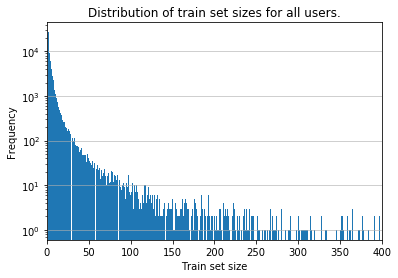

In [69]:
import matplotlib.pyplot as plt

all_training_sizes = []
for _, user in tqdm(users.items()):
    if user.is_test_user():
        all_training_sizes.append(len(user.train_review_ids))   

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=all_training_sizes, bins=1750)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Train set size')
plt.ylabel('Frequency')
plt.title('Distribution of train set sizes for all users.')
#maxfreq = n.max()
plt.yscale('log', nonposy='clip')
plt.xlim(0,400)
#plt.xscale('log')
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [6]:
import copy
import random
import time 
from scipy.sparse import csr_matrix

query_list, query_index = [], []
threshold = 0.7

if debug:
    max_reviews = 10000

else:
    max_reviews = 1e6

@dataclass
class Preference():
    sentiment: str
    sentence: Sentence
    review_id: str
    
    def get_parameters(self):
        return self.__dict__
        
def compute_score(relative_match_cnt):        
    if relative_match_cnt < -2: return 0.0
    elif relative_match_cnt == -2: return 1.0
    elif relative_match_cnt == -1: return 2.0
    elif relative_match_cnt == 0: return 2.5
    elif relative_match_cnt == 1: return 3.0
    elif relative_match_cnt == 2: return 4.0
    else: return 5.0
        
def compute_rmse(predicted_scores, gt_scores_array):        
    return np.sqrt(np.mean((predicted_scores - np.expand_dims(gt_scores_array, axis=1))**2,
                           axis=0))
    
def improve_user_rep(user, 
                     train_embeddings_from_train_movies_array, 
                     train_sentences_from_train_movies_index,
                     candidate_preferences,
                     train_polarised_embeddings_from_user_array,
                     train_polarised_sentiments_from_user_array,
                     gt_scores_array):
    
    initial_predicted_scores = np.expand_dims(2.5 * np.ones_like(gt_scores_array), axis=1)
    current_rmse = compute_rmse(initial_predicted_scores, gt_scores_array)[0]
    print("initial_rmse: ", current_rmse)
    similarity_scores = np.dot(train_embeddings_from_train_movies_array, 
                               train_polarised_embeddings_from_user_array.transpose()) # train_sentences_train_movies x train_polarised_sent_num
    #print("similarity_scores computed. similarity_scores: ", similarity_scores.shape)
    similarities_above_threshold = similarity_scores > threshold # train_sentences_train_movies x train_polarised_sent_num
    sum_reduced_similarities = np.add.reduceat(similarities_above_threshold, 
                                               train_sentences_from_train_movies_index) # train_movie_num x train_polarised_sent_num
    match_num_positive_bool = sum_reduced_similarities > 0 # train_movie_num x train_polarised_sent_num
    match_num_positive_bool = csr_matrix(match_num_positive_bool)
    #print("match_num_positive_bool: ", match_num_positive_bool)    
    masked_sentiments = np.diag(train_polarised_sentiments_from_user_array)
    masked_sentiments = csr_matrix(masked_sentiments)
    pos_positions = np.where(train_polarised_sentiments_from_user_array == 1)
    neg_positions = np.where(train_polarised_sentiments_from_user_array == -1)
    vfunc = np.vectorize(compute_score)
    while user.positive_slot_cnt < 5 or user.negative_slot_cnt < 5:
        relative_match_cnts = match_num_positive_bool.dot(masked_sentiments) # train_movie_num x train_polarised_sent_num
        relative_match_cnts = relative_match_cnts.toarray()
        #print("relative_match_cnts: ", relative_match_cnts)
        predicted_scores = vfunc(relative_match_cnts)
        #print("predicted_scores: ", predicted_scores)
        all_rmse = compute_rmse(predicted_scores, gt_scores_array)
        if user.positive_slot_cnt >= 5:
            all_rmse[pos_positions] = np.inf
        if user.negative_slot_cnt >= 5:
            all_rmse[neg_positions] = np.inf
        #print("all_rmse: ", all_rmse)
        min_rmse_idx = all_rmse.argmin()
        min_rmse = all_rmse[min_rmse_idx]
        
        sentiment = train_polarised_sentiments_from_user_array[min_rmse_idx]
        
        if min_rmse < current_rmse :
            print("min_rmse at step t: ", min_rmse)
            sentiment = train_polarised_sentiments_from_user_array[min_rmse_idx]
            masked_sentiments[min_rmse_idx, :] = sentiment
            if sentiment == 1:
                user.positive_slot_cnt += 1
            elif sentiment == -1:
                user.negative_slot_cnt += 1
            current_rmse = min_rmse
            user.add_preference(candidate_preferences[min_rmse_idx])
            
        else: 
            break
  
    print("final_rmse: ", current_rmse)
    print("================================================")
                    
for user_id in tqdm(test_user_ids):
    user = users[user_id]
    user.preferences = []
    gt_scores = []
    train_movie_ids = []
    user.positive_slot_cnt = 0
    user.negative_slot_cnt = 0
    
    for review in user.reviews(split="train"):
        gt_scores.append(review.score)
        train_movie_ids.append(review.movie_id)
    
    if len(train_movie_ids) > max_reviews:
        random.seed(SEED)
        random_indices = random.sample(range(len(user.train_review_ids)), max_reviews) 
        gt_scores = [gt_scores[i] for i in random_indices]
        train_movie_ids = [train_movie_ids[i] for i in random_indices]
    
    gt_scores_array = np.stack(gt_scores, axis=0)
    print("num train movies: ", len(gt_scores_array))

    train_embeddings_from_train_movies = []
    train_sentences_from_train_movies_index = [0]
    for movie_id in train_movie_ids:
        train_embeddings_from_movie = [sentence.to_array() 
                                       for sentence in movies[movie_id].review_sentences(split="train")]
        train_embeddings_from_train_movies.extend(train_embeddings_from_movie)
        train_sentences_from_train_movies_index.append(train_sentences_from_train_movies_index[-1] 
                                                       + len(train_embeddings_from_movie))

    train_embeddings_from_train_movies_array = np.stack(train_embeddings_from_train_movies, 
                                                        axis=0) # all_sentences_train_movies x h_dim
    train_sentences_from_train_movies_index = np.stack(train_sentences_from_train_movies_index[:-1], 
                                                       axis=0) # movie_num
    print("train_sentences_from_train_movies_index: ", train_sentences_from_train_movies_index.shape)

    train_polarised_embeddings_from_user = []
    train_polarised_sentiments_from_user = []
    candidate_preferences = []

    for sentence in user.review_sentences(split="train"):
        review = reviews[sentence.review_id]
        if review.movie_id in train_movie_ids:
            score = review.score
            review_id = review.review_id
            if score >= 4.0:
                sentiment = 1
                sentiment_str = "positive"
            elif score <= 2.0:
                sentiment = -1
                sentiment_str = "negative"
            else:
                sentiment = 0

            if sentiment != 0:
                candidate_preferences.append(Preference(sentiment_str, sentence, review_id))
                train_polarised_embeddings_from_user.append(sentence.to_array())
                train_polarised_sentiments_from_user.append(sentiment)

    train_polarised_embeddings_from_user_array = np.stack(train_polarised_embeddings_from_user, axis=0)
    train_polarised_sentiments_from_user_array = np.stack(train_polarised_sentiments_from_user, axis=0)

    improve_user_rep(user, 
                     train_embeddings_from_train_movies_array, 
                     train_sentences_from_train_movies_index,
                     candidate_preferences,
                     train_polarised_embeddings_from_user_array,
                     train_polarised_sentiments_from_user_array,
                     gt_scores_array)

    print([p.sentence.text for p in user.preferences])
    print()

    embedded_sentences = [p.sentence.to_array() 
                          for p in user.preferences] # Read embedding tensors associated with the preferences
    query_list.extend(embedded_sentences)
    query_index.extend([{"review_id": p.review_id, 
                         "sentiment": p.sentiment,
                         "user_id": user_id, 
                         "text": p.sentence.text} for p in user.preferences])
    user.query_review_num = len(user.preferences)
    
query_array = np.stack(query_list, axis=0)
print("queries shape: ", query_array.shape)

num train movies:  8
train_sentences_from_train_movies_index:  (8,)
initial_rmse:  1.5811388300841898
min_rmse at step t:  1.1989578808281798
min_rmse at step t:  0.6373774391990981
min_rmse at step t:  0.39528470752104744
min_rmse at step t:  0.1767766952966369
final_rmse:  0.1767766952966369
["It's a great little movie that entertains .", 'This movie draws me to watch it again and again .', 'The dialogue was wonderful and I think the movie does capture one of the seminal reasons that people fought for either side during the war . . .', 'This movie is a real gem and John Huston does a remarkable job in creating a fairly realistic looking Civil War environment .']

num train movies:  10


/home/infres/llaugier/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


train_sentences_from_train_movies_index:  (10,)
initial_rmse:  1.2041594578792296
min_rmse at step t:  1.036822067666386
min_rmse at step t:  0.8944271909999159
min_rmse at step t:  0.7416198487095663
min_rmse at step t:  0.6519202405202649
min_rmse at step t:  0.570087712549569
min_rmse at step t:  0.4743416490252569
min_rmse at step t:  0.3535533905932738
min_rmse at step t:  0.22360679774997896
min_rmse at step t:  0.15811388300841897
final_rmse:  0.15811388300841897
['Great transfer of a great film !', '.', 'I could go on , but why bother ?', 'I cannot believe I waited 20 years for this .', 'I loved the original " Lost Boys " .', "Most places won ' t have it til October , but Best Buy has the blu ray exclusively starting today .", 'Benji was a giant part of my childhood .', 'Miserable Blu Ray release of a great movie .', 'Performances : GoodDirection : GoodCinematography : GoodSound / other techincal aspects : GoodTitle : MISLEADINGI will give in to the reviews that this was a good

train_sentences_from_train_movies_index:  (36,)
initial_rmse:  2.1147629234082532
min_rmse at step t:  1.6687486995417322
min_rmse at step t:  0.9753916592266354
min_rmse at step t:  0.816496580927726
min_rmse at step t:  0.7453559924999299
min_rmse at step t:  0.6666666666666666
min_rmse at step t:  0.6009252125773316
min_rmse at step t:  0.5833333333333334
min_rmse at step t:  0.5773502691896257
final_rmse:  0.5773502691896257
['One of my favourite movies .', 'Brilliant movie .', 'Highly reccomended .', 'When this DVD first came out I was tempted to buy it but kept changing my mind as the past couple of comedy horrors I watched were really bad and , in my opinion , it is very difficult to make a good comedy horror because you need to know just the right ammount of comedy to add into the mix to make the movie funny - but not so much that it totally kills the horror and suspense elements of the movie .', 'For a start you dont actually see very many of the murders ( and this is the uncu

train_sentences_from_train_movies_index:  (1,)
initial_rmse:  1.5
min_rmse at step t:  1.0
min_rmse at step t:  0.0
final_rmse:  0.0
['I expected this movie to be corny , as the original tv show was .', 'sometimes I felt the images were too contrived - but it was a good escape']

num train movies:  1
train_sentences_from_train_movies_index:  (1,)
initial_rmse:  2.5
min_rmse at step t:  2.0
min_rmse at step t:  1.0
min_rmse at step t:  0.0
final_rmse:  0.0
['One of the best comic book movies out there .', 'Made even more amazing in 3D .', 'Funny , gripping , and very entertaining .']

num train movies:  2
train_sentences_from_train_movies_index:  (2,)
initial_rmse:  2.5
min_rmse at step t:  2.0
min_rmse at step t:  1.0
min_rmse at step t:  0.0
final_rmse:  0.0
['great movie , my girls love all three barbie christmas movies , this has always been a hit at our house .', 'my girls love barbie movies , this is just a fun christmas movie that they enjoy with their other movies .', 'thanks']


train_sentences_from_train_movies_index:  (4,)
initial_rmse:  1.9364916731037085
min_rmse at step t:  1.620185174601965
min_rmse at step t:  1.346291201783626
min_rmse at step t:  1.0307764064044151
min_rmse at step t:  0.8660254037844386
min_rmse at step t:  0.7071067811865476
final_rmse:  0.7071067811865476
['This movie had so many great zingers ( i.e.', "This is by far the funniest movie I ' ve ever seen .", 'By far the best of the " Mutated Monster " movies !', "Where's the fire ?", 'If you don \' t find this movie to be " sinfully funny " you don \' t have a sense of humor !']

num train movies:  12
train_sentences_from_train_movies_index:  (12,)
initial_rmse:  1.7559422921421233
min_rmse at step t:  1.4577379737113252
min_rmse at step t:  1.20761472884912
min_rmse at step t:  1.0206207261596576
min_rmse at step t:  0.9464847243000456
min_rmse at step t:  0.8897565210026093
min_rmse at step t:  0.82915619758885
min_rmse at step t:  0.7772815877574012
min_rmse at step t:  0.7216878

train_sentences_from_train_movies_index:  (2,)
initial_rmse:  2.5
min_rmse at step t:  2.0
min_rmse at step t:  1.0
min_rmse at step t:  0.0
final_rmse:  0.0
['I read the reviews for this movie and decided to buy it .', 'I am so glad I bought this movie , amazing , truly amazing . . . .', 'I have wanted to see this movie for a long time and finally I bought it and it was so worth the wait !']

num train movies:  17
train_sentences_from_train_movies_index:  (17,)
initial_rmse:  2.428386053231531
min_rmse at step t:  2.1074098961968066
min_rmse at step t:  1.6087993330796875
min_rmse at step t:  1.3503812097939996
min_rmse at step t:  1.2833778958394957
min_rmse at step t:  1.212678125181665
final_rmse:  1.212678125181665
['This will always be one of my all - time favorite flix !', 'This movie truly blew me away !', 'Enjoyed it immensely !', 'This has got to be # 1 on my list of must see movies for all of us , overweight , overworked or whatever .', 'This once again I fanciful tale of gr

train_sentences_from_train_movies_index:  (13,)
initial_rmse:  2.170607855311148
min_rmse at step t:  1.7595891128765961
min_rmse at step t:  1.2480754415067656
min_rmse at step t:  1.1519214716824566
min_rmse at step t:  1.0741723110591492
min_rmse at step t:  1.0
final_rmse:  1.0
['Very nice movie , and the DVD was in VERY GOOD shape , The movie is a classicand well worth watching .', 'it was a good movie , i will watch this more then once , great story line and awsome job on all actors parts', "it's Clint Eastwood for goodness sakes , he's awesome , i ' m thinking he has only madea couple bad movies , but these aren ' t it , first time I seen these movies was at the Drive in move .", "I am a huge Red Skelton fan , so they don ' t have enough stars , cause it's way beyond 5 starsto me anyway , this guy is the KING of comedy in my book .", 'great story line and what a twist , keeps you on your feet and keeps you thinking , the ending was very nice']

num train movies:  1
train_sentenc

train_sentences_from_train_movies_index:  (27,)
initial_rmse:  1.9317042945237455
min_rmse at step t:  1.7821127702606046
min_rmse at step t:  1.6273131684307567
min_rmse at step t:  1.53055303488399
min_rmse at step t:  1.4433756729740645
min_rmse at step t:  1.3911093361721016
min_rmse at step t:  1.3402597868683133
min_rmse at step t:  1.308802109932194
min_rmse at step t:  1.2838022231434825
min_rmse at step t:  1.2619796324000607
min_rmse at step t:  1.243501626977744
final_rmse:  1.243501626977744
['I loved it !', 'This movie was actually really funny and she did great in this role !', 'I bet that the MAJORITY of the bad reviews here came from people that have not watched this movie and / or have cold hearts .', 'Give this movie a chance , even just out of curiosity - you never know , you may become a fan .', 'Anyway , This is a super cute movie and any decent - hearted person would appreciate it even if you do not like Paris Hilton which I personally do not like NOR dislike .', 

train_sentences_from_train_movies_index:  (9,)
initial_rmse:  1.8929694486000912
min_rmse at step t:  1.6414763002993509
min_rmse at step t:  1.4240006242195884
min_rmse at step t:  1.2801909579781015
min_rmse at step t:  1.118033988749895
min_rmse at step t:  0.97182531580755
min_rmse at step t:  0.8333333333333334
min_rmse at step t:  0.7453559924999299
min_rmse at step t:  0.6666666666666666
min_rmse at step t:  0.5773502691896257
min_rmse at step t:  0.4714045207910317
final_rmse:  0.4714045207910317
['I first saw this film in the theatre when it came out in 1998 .', 'I saw it last night again .', 'but the cast and acting were all good .', 'This is a stunning and lovely film .', '" Well here\'s why not .', 'When I first saw the previews for this film , I was expecting an intriguing and entertaining journey of self discovery .', 'Like other reviewers , I found MeetThe Parents mildly amusing and this sequel was in the 3 for $25 bin at Hollywood so I figured " Why not ?', 'This was a 

train_sentences_from_train_movies_index:  (11,)
initial_rmse:  1.3734495390671027
min_rmse at step t:  1.0660035817780522
min_rmse at step t:  0.7537783614444091
min_rmse at step t:  0.621581560508061
min_rmse at step t:  0.5222329678670935
min_rmse at step t:  0.4264014327112209
min_rmse at step t:  0.30151134457776363
min_rmse at step t:  0.0
final_rmse:  0.0
['Anyways , this movie was a total nonsense .', 'So many people have given this movie 5 stars , so I decided to rent this movie .', "Some people knock this film because it contains marshall arts , but come on people , it's not like the fight scenes are pooley done , it's one of the best fight scenes that I have ever seen .", 'This film is made up of not only very good acting from all of the actores and actresses , but also contain some of the great and beautiful sceneries as well .', 'I could not put my finger on just why I was getting this feeling until I saw this scene .', 'This film also containes some eye candies that you wi

## ScaNN search

In [7]:
import time

import scann

num_neighbors = 10

dataset = dataset_array

normalized_dataset = dataset_array / np.linalg.norm(dataset, axis=1)[:, np.newaxis]

searcher = scann.scann_ops_pybind.builder(normalized_dataset, num_neighbors, "dot_product").tree(
    num_leaves=2000, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [8]:
start = time.time()
neighbors, distances = searcher.search_batched(query_array, final_num_neighbors=num_neighbors)
end = time.time()

print(neighbors.shape)

(464, 10)


In [ ]:
for i in range(neighbors.shape[0]):
    print("query: ", queries_index[i]["text"])
    print("nearest neighbor: ", dataset_index[neighbors[i][1]]["text"], " --------- Similarity: ", distances[i][1])
    print()

## Compute score

### Get recommended movies

In [9]:
# Some preprocessing
import tensorflow as tf

def map_raw_ids_to_sequential_ids(users):
    """
    For each unique user or movie id, this function creates a mapping to a sequence of number starting in 0.
    This will be the index of the embeddings in the model.
    Movies ids will be from 0 to n_movies - 1.
    Users ids will be from n_movies to n_movies + n_users - 1
    :param users: dict of <user_id>: user
    :return: dicts of {<user_idX>: indexY} and {<movie_idX>: indexW}
    """
    user_id2id, movie_id2id = {}, {}
    sorted_samples = sorted(users.items(), key=lambda x: x[0])
    # first sets movies ids only
    for _, user in sorted_samples:
        ints = [review.movie_id for review in user.reviews(split="all")]
        sorted_ints = sorted(ints)
        for movie_id in sorted_ints:
            if movie_id not in movie_id2id:
                movie_id2id[movie_id] = len(movie_id2id)
    # users ids come after item ids
    for user_id, _ in sorted_samples:
        if user_id not in user_id2id:
            user_id2id[user_id] = len(user_id2id) + len(movie_id2id)

    return user_id2id, movie_id2id

user_id2id, movie_id2id = map_raw_ids_to_sequential_ids(users)
id2movie_id = {v: k for k, v in movie_id2id.items()}
id2user_id = {v: k for k, v in user_id2id.items()}

In [19]:
# Hit Rate v1: Prediction based on ScaNN
def compute_nnscore(test_user_id, start_query_id, users, neighbors, distances, query_index, dataset_index, 
                  movie_id2id):
    user = users[test_user_id]
    query_review_num = user.query_review_num
    predictions = np.zeros(len(movies))
    for j in range(query_review_num):
        sentiment = query_index[start_query_id+j]["sentiment"]
        for k in range(num_neighbors):
            candidate_prediction_info = dataset_index[neighbors[start_query_id + j][k]]
            candidate_prediction_movie_id = candidate_prediction_info["movie_id"]
            candidate_prediction_id = movie_id2id[candidate_prediction_movie_id]
            sentiment_increment = 1 if sentiment == "positive" else -1
            predictions[candidate_prediction_id] +=  sentiment_increment
    
    dev_target = predictions[movie_id2id[reviews[user.dev_pos_review_id].movie_id]]
    test_target = predictions[movie_id2id[reviews[user.test_pos_review_id].movie_id]]
    start_query_id += query_review_num

    return dev_target, test_target, predictions, start_query_id
        

def random_eval(users, neighbors, distances, query_index, dataset_index, movie_id2id, num_rand=100, seed=1234):
        """
        Compute ranking-based evaluation metrics in both full and random settings.
        users: 
      id2user_id: Dict of mapping between sequential id and user_id.
      movie_id2id: Dict of mapping between movie_id and sequential_id
        
        
        :param users: Dict representing the users.
        :param neighbors: Numpy array with tensor of size n_queries x 10 containing the id of the 10 nearest 
         sentences.
        :param distances: Numpy array with tensor of size n_queries x 10 containing the similarities of the
         10 nearest sentences.
        :param query_index: List of dicts containing info about the query sentences.
        :param dataset_index: List of dicts containing info about the dataset sentences.
        :movie_id2id: Dict mapping movie_id to sequential ids.
        :param num_rand: number of negative samples to draw.
        :param seed: seed for random sampling.
        :return: dev_ranks, test_ranks: Numpy array of shape (n_examples, ) containing the rank of each example
         in full setting (ranking against the full item corpus).
                dev_ranks_random, test_ranks_random: Numpy array of shape (n_examples, ) containing the rank of
                each example in random setting (ranking against randomly selected num_rand items).
        """
        total_examples = len(test_user_ids)
        #batch_size = min(batch_size, total_examples)
        dev_ranks = np.ones(total_examples)
        dev_ranks_random = np.ones(total_examples)
        
        test_ranks = np.ones(total_examples)
        test_ranks_random = np.ones(total_examples)
        
        start_query_id = 0
        for counter, test_user_id in enumerate(test_user_ids):
            dev_target, test_target, scores, start_query_id = compute_nnscore(test_user_id, start_query_id, users, 
                                                                              neighbors, distances, query_index,
                                                                              dataset_index, movie_id2id)
            scores_random = np.ones(shape=(num_rand))
            filter_out =[movie_id2id[review.movie_id] for review in users[test_user_id].reviews()]
            scores[filter_out] = -1e6  # sets that value on scores of train / dev / test items
            comp_filter_out = list(set(range(scores.shape[0])) - set(filter_out))
            np.random.seed(seed)
            random_indices = np.random.choice(comp_filter_out, num_rand, replace=False)
            scores_random = scores[random_indices]  # copies the indices chosen for evaluation

            dev_ranks[counter] += np.sum((scores >= dev_target))
            dev_ranks_random[counter] += np.sum((scores_random >= dev_target))
            
            test_ranks[counter] += np.sum((scores >= test_target))
            test_ranks_random[counter] += np.sum((scores_random >= test_target))
        #print("dev_ranks_random: ", dev_ranks_random)
        #print("test_ranks_random: ", test_ranks_random)
        #print()

        return dev_ranks, dev_ranks_random, test_ranks, test_ranks_random

def rank_to_metric_dict(ranks):
    mean_rank = np.mean(ranks)
    std_rank = np.std(ranks)
    mean_reciprocal_rank = np.mean(1. / ranks)
    metrics = {'MR': (mean_rank, std_rank), 'MRR': (mean_reciprocal_rank, np.NAN)}
    for k in (1, 3, 10):
        metrics[f'HR@{k}'] = (np.mean(ranks <= k) * 100, np.NAN)
    return metrics
    
def compute_metrics(users, neighbors, distances, query_index, dataset_index, movie_id2id):
    random_items = 100
    dev_rank_all, dev_rank_random, test_rank_all, test_rank_random = random_eval(users, neighbors, distances,
                                                                                 query_index, dataset_index,
                                                                                 movie_id2id, 
                                                                                 num_rand=random_items)
    
    dev_metric_all, dev_metric_random = rank_to_metric_dict(dev_rank_all), rank_to_metric_dict(dev_rank_random)
    test_metric_all, test_metric_random = rank_to_metric_dict(test_rank_all), rank_to_metric_dict(test_rank_random)

    dev_var_all, dev_var_random = rank_to_var_dict(dev_rank_all), rank_to_var_dict(dev_rank_random)
    test_var_all, test_var_random = rank_to_var_dict(test_rank_all), rank_to_var_dict(test_rank_random)
    
    print(f"Result for DEV")
    print(f"Random items {random_items}: " + " ".join((f"{k}: {v[0]:.2f} +/- {v[1]:.2f}" for k, v in dev_metric_random.items())))
    print("All items: " + " ".join((f"{k}: {v[0]:.2f} +/- {v[1]:.2f}" for k, v in dev_metric_all.items())))
    print()
    print(f"Result for TEST")
    print(f"Mean")
    print(f"Random items {random_items}: " + " ".join((f"{k}: {v[0]:.2f} +/- {v[1]:.2f}" for k, v in test_metric_random.items())))
    print("All items: " + " ".join((f"{k}: {v[0]:.2f} +/- {v[1]:.2f}" for k, v in test_metric_all.items())))
    
    return dev_metric_all, dev_metric_random, test_metric_all, test_metric_random


dev_metric_all, dev_metric_random, test_metric_all, test_metric_random = compute_metrics(users, 
                                                                                         neighbors, 
                                                                                         distances, 
                                                                                         query_index, 
                                                                                         dataset_index, 
                                                                                         movie_id2id)

Result for DEV
Random items 100: MR: 99.95 +/- 9.95 MRR: 0.02 +/- nan HR@1: 1.00 +/- nan HR@3: 1.00 +/- nan HR@10: 1.00 +/- nan
All items: MR: 24126.53 +/- 2424.68 MRR: 0.00 +/- nan HR@1: 0.00 +/- nan HR@3: 1.00 +/- nan HR@10: 1.00 +/- nan

Result for TEST
Mean
Random items 100: MR: 97.95 +/- 17.05 MRR: 0.04 +/- nan HR@1: 3.00 +/- nan HR@3: 3.00 +/- nan HR@10: 3.00 +/- nan
All items: MR: 23641.10 +/- 4153.12 MRR: 0.01 +/- nan HR@1: 1.00 +/- nan HR@3: 1.00 +/- nan HR@10: 1.00 +/- nan


In [32]:
# RMSE

def predict_scores(user, movies, movie_ids):
    train_embeddings_from_movies = []
    train_sentences_from_movies_index = [0]
    for movie_id in movie_ids:
        train_embeddings_from_movie = [sentence.to_array() 
                                       for sentence in movies[movie_id].review_sentences(split="train")]
        train_embeddings_from_movies.extend(train_embeddings_from_movie)
        train_sentences_from_movies_index.append(train_sentences_from_movies_index[-1] 
                                                 + len(train_embeddings_from_movie))

    train_embeddings_from_movies_array = np.stack(train_embeddings_from_movies, 
                                                  axis=0) # train_sentences_from_movies x h_dim
    train_sentences_from_movies_index = np.stack(train_sentences_from_movies_index[:-1], axis=0) # movie_num

    preference_sentences = []
    preference_sentiments = []
    for preference in user.preferences:
        preference_sentences.append(preference.sentence.to_array())
        if preference.sentiment == "positive":
            preference_sentiments.append(1)
        elif preference.sentiment == "negative":
            preference_sentiments.append(-1)
        else:
            raise RuntimeError("Preference neither 'positive' nor 'negative'.")

    preference_sentences_array = np.stack(preference_sentences, axis=0)
    preference_sentiments = np.stack(preference_sentiments, axis=0)

    similarity_scores = np.dot(train_embeddings_from_movies_array, 
                               preference_sentences_array.transpose()) # train_sentences_movies x preferences_num
    similarities_above_threshold = similarity_scores > threshold # train_sentences_movies x preferences_num
    sum_reduced_similarities = np.add.reduceat(similarities_above_threshold, 
                                               train_sentences_from_movies_index) # movie_num x preferences_num
    match_num_positive_bool = sum_reduced_similarities > 0 # movie_num x preferences_num
    vfunc = np.vectorize(compute_score)

    relative_match_cnts = np.dot(match_num_positive_bool, preference_sentiments) # ,    movie_num x 1

    scores = vfunc(relative_match_cnts) # movie_num x 1

    return scores
    
def get_predicted_scores_for_alleval(split, users, movies):
    gt_scores = []
    predicted_scores = []

    for test_user_id in tqdm(test_user_ids):
        user = users[test_user_id]
        eval_movie_ids = []

        for review in user.reviews(split=split):
            gt_scores.append(review.score)
            eval_movie_ids.append(review.movie_id)
            
        predicted_scores_user = predict_scores(user, movies, eval_movie_ids)
        predicted_scores.extend(predicted_scores_user.tolist())     

    return predicted_scores, gt_scores

for split in ("dev", "test"):
    predicted_scores, gt_scores = get_predicted_scores_for_alleval(split, users, movies)
    rmse = np.sqrt(np.mean((np.array(predicted_scores) - np.array(gt_scores))**2,  axis=0))
    print(f"Result for {split.upper()}")
    print(f"RMSE: {rmse:.2f}")     

ERROR! Session/line number was not unique in database. History logging moved to new session 101

Result for DEV
RMSE: 1.69



Result for TEST
RMSE: 1.71


In [20]:
# Hit Rate v2: Prediction based on the same selection process that create preferences

def get_predicted_scores_for_random_and_poseval(test_user_id, users, movies, num_rand=100, seed=1234):
    user = users[test_user_id]
    filter_out =[review.movie_id for review in user.reviews()]
    comp_filter_out = list(set(movies.keys()) - set(filter_out))
    np.random.seed(seed)
    random_movie_ids = np.random.choice(comp_filter_out, num_rand, replace=False)
    scores_random = np.ones(shape=(num_rand))
    
    predictions_random = predict_scores(user, movies, random_movie_ids)
    dev_target = predict_scores(user, movies, [reviews[user.dev_pos_review_id].movie_id])
    test_target = predict_scores(user, movies, [reviews[user.test_pos_review_id].movie_id])
    
    return dev_target, test_target, predictions_random
        

def random_eval_2(users, movies, num_rand=100, seed=1234):
        """
        Compute ranking-based evaluation metrics in both full and random settings.
        :param users: Dict representing the users.
        :param movies: Dict representing the movies.
        :param num_rand: number of negative samples to draw.
        :param seed: seed for random sampling.
        :return: dev_ranks_random, test_ranks_random: Numpy array of shape (n_examples, ) containing the rank of
                 each example in random setting (ranking against randomly selected num_rand items).
        """
        total_examples = len(test_user_ids)
        #batch_size = min(batch_size, total_examples)
        dev_ranks_random = np.ones(total_examples)
        test_ranks_random = np.ones(total_examples)
        
        for counter, test_user_id in tqdm(enumerate(test_user_ids)):
            dev_target, test_target, scores_random = get_predicted_scores_for_random_and_poseval(test_user_id,
                                                                                                 users,
                                                                                                 movies,
                                                                                                 num_rand=num_rand,
                                                                                                 seed=seed)
            dev_ranks_random[counter] += np.sum((scores_random >= dev_target))
            test_ranks_random[counter] += np.sum((scores_random >= test_target))

        return dev_ranks_random, test_ranks_random

    
def compute_metrics_2(users, movies):
    random_items = 100
    dev_rank_random, test_rank_random = random_eval_2(users, movies, num_rand=random_items)
    
    dev_metric_random = rank_to_metric_dict(dev_rank_random)
    test_metric_random = rank_to_metric_dict(test_rank_random)

    print(f"Result for DEV")
    print(f"Mean")
    print(f"Random items {random_items}: " + " ".join((f"{k}: {v[0]:.2f} +/- {v[1]:.2f}" for k, v in dev_metric_random.items())))
    print()
    print(f"Result for TEST")
    print(f"Mean")
    print(f"Random items {random_items}: " + " ".join((f"{k}: {v[0]:.2f} +/- {v[1]:.2f}" for k, v in test_metric_random.items())))

    return dev_metric_random, test_metric_random

dev_metric_random, test_metric_random = compute_metrics_2(users, movies)


Result for DEV
Mean
Random items 100: MR: 55.69 +/- 40.14 MRR: 0.10 +/- nan HR@1: 5.00 +/- nan HR@3: 10.00 +/- nan HR@10: 18.00 +/- nan

Result for TEST
Mean
Random items 100: MR: 55.27 +/- 39.52 MRR: 0.06 +/- nan HR@1: 1.00 +/- nan HR@3: 2.00 +/- nan HR@10: 15.00 +/- nan


In [ ]:
"""
- Human eval study
- mocks.
- metrics  
"""

## Random baseline

In [67]:
# Hit Rate
np.random.seed(SEED)
random_ranking = np.expand_dims(np.random.permutation(len(movies)), axis=0)

random_movies = 100
for title, split in zip(["DEV", "TEST"], [pos_dev, pos_test]):
    rank_all, rank_random = random_eval_0(random_ranking, split, users, id2user_id, movie_id2id, num_rand=random_movies, seed=SEED)
    metric_all, metric_random = rank_to_metric_dict(rank_all), rank_to_metric_dict(rank_random)

    print(f"Result for {title.upper()}")
    print(f"Random movies {random_movies}: " + " ".join((f"{k}: {v:.2f}" for k, v in metric_random.items())))
    print("All movies: " + " ".join((f"{k}: {v:.2f}" for k, v in metric_all.items())))


Result for DEV
Random movies 100: MR: 51.59 MRR: 0.05 HR@1: 1.20 HR@3: 3.02 HR@10: 8.91
All movies: MR: 12230.31 MRR: 0.00 HR@1: 0.00 HR@3: 0.00 HR@10: 0.02



Result for TEST
Random movies 100: MR: 52.07 MRR: 0.05 HR@1: 1.13 HR@3: 2.93 HR@10: 8.79
All movies: MR: 12353.18 MRR: 0.00 HR@1: 0.00 HR@3: 0.00 HR@10: 0.02


In [64]:
# RMSE 

predicted_scores = {"dev": [], "test": []}
gt_scores = {"dev": [], "test": []}

for user_id, user in tqdm(users.items()): 
    for split in ("dev", "test"):
        for review in user.reviews(split=split):
            gt_scores[split].append(review.score)
            random.seed(SEED)
            score = random.randint(1, 5)
            predicted_scores[split].append(score)

            
for split in ("dev", "test"):
    rmse = np.sqrt(np.mean((np.array(predicted_scores[split]) - np.array(gt_scores[split]))**2,  axis=0))
    print(f"Result for {split.upper()}")
    print(f"RMSE: {rmse:.2f}") 


Result for DEV
RMSE: 3.47
Result for TEST
RMSE: 3.45
